In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
project_path = "/content/drive/MyDrive/JOBcn_presencial/"



In [156]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [182]:
df = pd.read_csv(project_path+"train.csv")
df.head(2)

,Unnamed: 0,red_card_continent,age,nation,league,team,goals_selection,selections_nation,position,price,...,assist_cup,own_goal_cup,yellow_card_cup,second_yellow_card_cup,red_card_cup,goal_continent,assist_continent,own_goal_continent,yellow_card_continent,second_yellow_card_continent
0,1019,0.0,23,Tunisia,Ligue1,OGCNice,0,4,Goalkeeper,1000000.0,...,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0
1,1892,0.0,20,CzechRepublic,FortunaLiga,1.FKPribram,0,1,LeftWinger,100000.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [183]:
df.columns

Index(['Unnamed: 0', 'red_card_continent', 'age', 'nation', 'league', 'team',
       'goals_selection', 'selections_nation', 'position', 'price',
       'goal_champ', 'assist_champ', 'own_goal_champ', 'yellow_card_champ',
       'second_yellow_card_champ', 'red_card_champ', 'goal_cup', 'assist_cup',
       'own_goal_cup', 'yellow_card_cup', 'second_yellow_card_cup',
       'red_card_cup', 'goal_continent', 'assist_continent',
       'own_goal_continent', 'yellow_card_continent',
       'second_yellow_card_continent'],
      dtype='object')

In [184]:
#df['league'].unique()
df.selections_nation	
len(df.team.unique())

1049

In [185]:
class FeatureEngineeringDf:
  def __init__(self, df):
    self.df = df
    self.top_leagues = ['Ligue1', 'PremierLeague', 'LaLiga', 'SerieA', 'Bundesliga']
    self.top_nations = ['Brazil', 'Spain', 'France', 'Germany', 'Belgium', 'Argentina', 'Italy','England', 'Portugal']
    self.worst_leagues = []
    self.worst_nations = []
    self.condlist_top_leagues = [
        self.df['league'].isin(self.top_leagues),
        ~self.df['league'].isin(self.top_leagues),
    ]
    self.condlist_top_nations = [
        self.df['nation'].isin(self.top_nations),
        ~self.df['nation'].isin(self.top_nations),
    ]
    #self.init_dtypes()

  def init_dtypes(self):
    for col in self.df.columns:
      if col != "pollutant":
          if is_string_dtype(self.df[col]):
              print("str", col)
              self.df[col] = self.df[col].astype('category').cat.codes
          elif is_numeric_dtype(self.df[col]):
              print("int", col)
              self.df[col] = self.df[col].astype(np.int64)
    
  def add_goals_value(self):
    choicelist_cup = [
        self.df['goal_cup']*2,
        self.df['goal_cup'],
    ]
    self.df['score_goal_cup'] = np.select(self.condlist_top_leagues, choicelist_cup, default=0)
    choicelist_champ = [
        self.df['goal_champ']*2,
        self.df['goal_champ'],
    ]
    self.df['score_goal_champ'] = np.select(self.condlist_top_leagues, choicelist_champ, default=0)

    choicelist_champ = [
        self.df['goals_selection']*2,
        self.df['goals_selection'],
    ]
    self.df['score_goals_selection'] = np.select(self.condlist_top_nations, choicelist_champ, default=0)
  
  def add_assists_value(self):
    choicelist_cup = [
        self.df['assist_cup']*2,
        self.df['assist_cup'],
    ]
    self.df['score_assist_cup'] = np.select(self.condlist_top_leagues, choicelist_cup, default=0)
    choicelist_champ = [
        self.df['assist_champ']*2,
        self.df['assist_champ'],
    ]
    self.df['score_assist_champ'] = np.select(self.condlist_top_leagues, choicelist_champ, default=0)

  def champions_score(self):
    # dividir continents --> TO DO
      choicelist_champ = [
          self.df['assist_continent']*2,
          self.df['assist_continent'],
      ]
      self.df['score_assist_continent'] = np.select(self.condlist_top_nations, choicelist_champ, default=0)

      choicelist_champ = [
          self.df['goal_continent']*2,
          self.df['goal_continent'],
      ]
      self.df['score_goal_continent'] = np.select(self.condlist_top_nations, choicelist_champ, default=0)

  
  def add_nations_value(self):
    choicelist_champ = [
        self.df['selections_nation']*2,
        self.df['selections_nation'],
    ]
    self.df['score_selections_nation'] = np.select(self.condlist_top_nations, choicelist_champ, default=0)
  
  def filter_by_position(self, filter=0):
    if filter == 0:
      return self.df[self.df.position.isin(['Goalkeeper'])]
    elif filter == 1:
      return self.df[self.df.position.isin([ 'DefensiveMidfield','Defender'])]
    elif filter == 2:
      return self.df[self.df.position.isin(['LeftMidfield' , 'CentralMidfield', 'Midfielder', 'AttackingMidfield','RightMidfield'])]
    else:
      return self.df[self.df.position.isin(['SecondStriker', 'Forward','LeftWinger','RightWinger'])]
  
  def filter_top_leagues(self, filter_positions=True, positions = ['SecondStriker', 'Forward']):
    top_league_players = self.df[self.df.league.isin(self.top_leagues)]
    if filter_positions:
      top_league_players[top_league_players.position.isin(positions)]
    return top_league_players
  
  def data_correlated(self,label_col_name='price'):
      corr = self.df.corr().abs()['price']
      corr = corr[corr != 1]
      corr = corr[corr > 0.05]
      select_columns = list(corr.index)
      select_columns.remove('Unnamed: 0')
      df_select_columns = self.df[select_columns]
      y = self.df[label_col_name]
      return df_select_columns.copy(), y.copy()



In [186]:
data = FeatureEngineeringDf(df)
data.add_goals_value()
data.add_assists_value()
data.add_nations_value()
data.df

,Unnamed: 0,red_card_continent,age,nation,league,team,goals_selection,selections_nation,position,price,...,own_goal_continent,yellow_card_continent,second_yellow_card_continent,score_goal_cup,score_goal_champ,score_goal_continent,score_assist_cup,score_assist_champ,score_assist_continent,score_selections_nation
0,1019,0.0,23,Tunisia,Ligue1,OGCNice,0,4,Goalkeeper,1000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,1892,0.0,20,CzechRepublic,FortunaLiga,1.FKPribram,0,1,LeftWinger,100000.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1
2,2548,7.0,31,Canada,SuperLiga,RedStar,0,40,Goalkeeper,3000000.0,...,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,3137,0.0,22,Belgium,JupilerProLeague,ClubBrugge,4,18,SecondStriker,4000000.0,...,0.0,2.0,0.0,0.0,33.0,0.0,3.0,22.0,2.0,36
4,2576,0.0,29,Ukraine,PremierLiga,Chornomorets,0,0,LeftMidfield,500000.0,...,0.0,0.0,0.0,0.0,20.0,0.0,0.0,19.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8892,3659,0.0,24,Russia,PremierLiga,ArsenalTula,0,0,Goalkeeper,125000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8893,9063,0.0,24,Uruguay,PrimeraDivisión,Argentinos,0,0,AttackingMidfield,300000.0,...,0.0,0.0,0.0,2.0,12.0,0.0,1.0,10.0,0.0,0
8894,9163,0.0,29,Argentina,PrimeraDivisión,Defensa,0,11,Goalkeeper,800000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22
8895,2980,0.0,29,Argentina,SuperLeague,ApollonSmyrnis,1,2,AttackingMidfield,300000.0,...,0.0,0.0,0.0,0.0,19.0,0.0,1.0,29.0,2.0,4


In [187]:
def plot_corr(df):
  correlation = df.corr()
  plt.figure(figsize=(18,15))
  heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

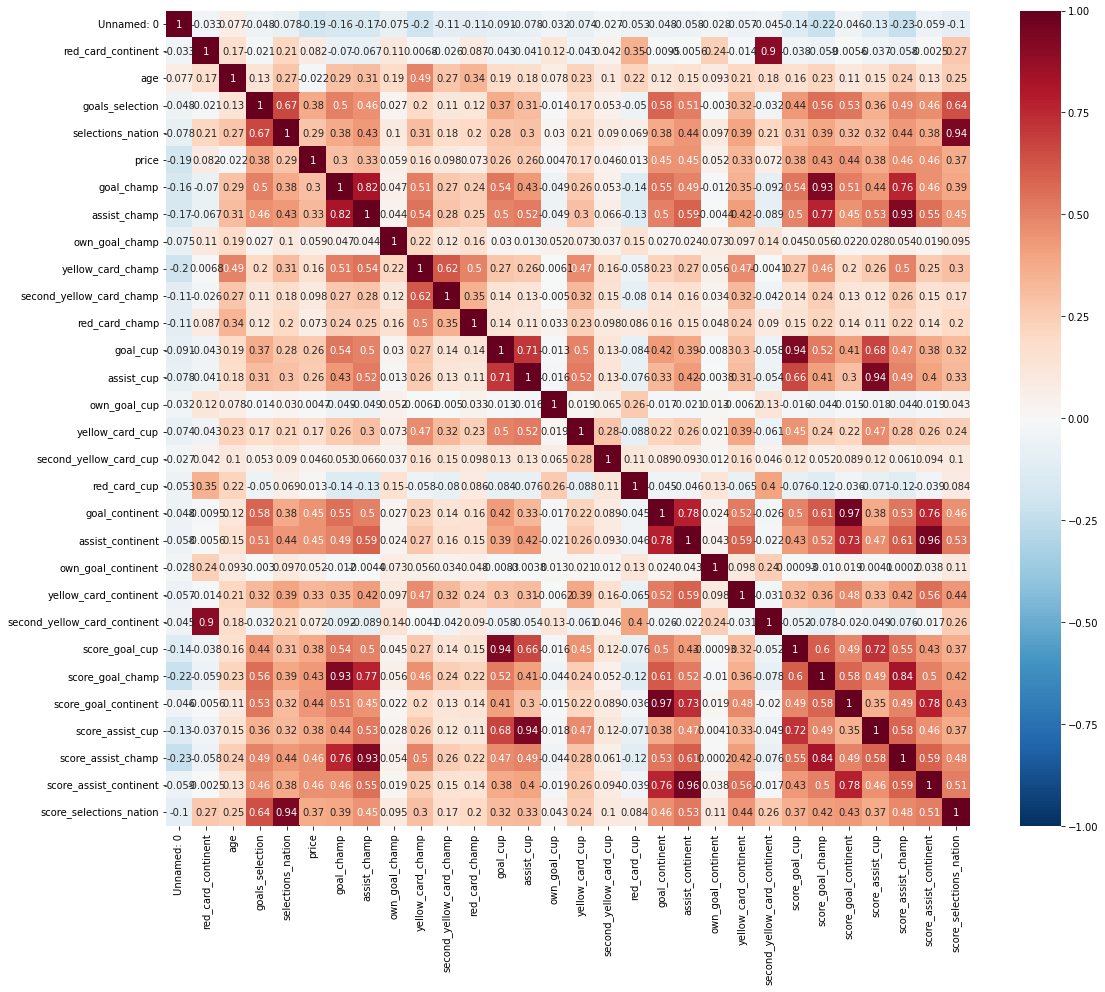

In [188]:
plot_corr(data.df)

## Goalkeeper

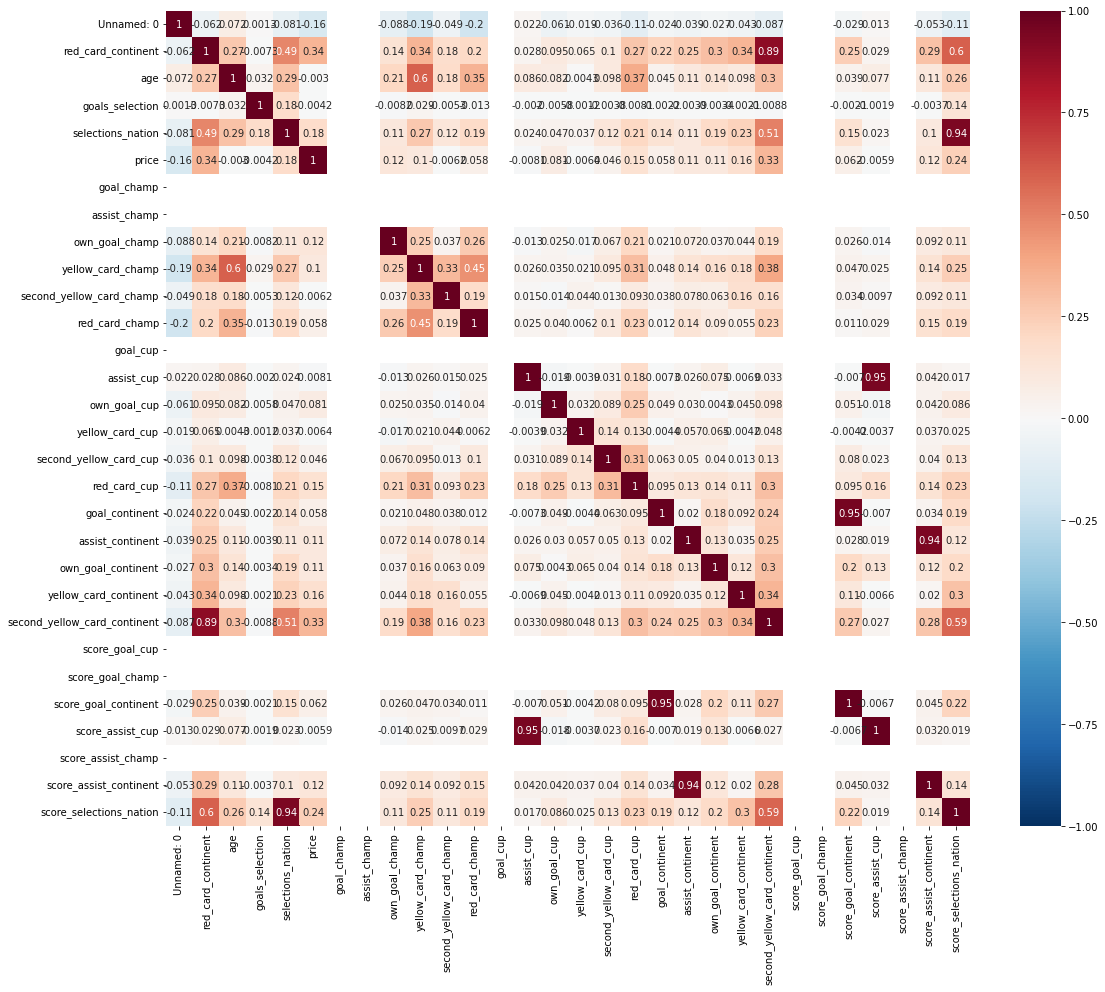

In [189]:
plot_corr(data.filter_by_position(0))

## Defenders

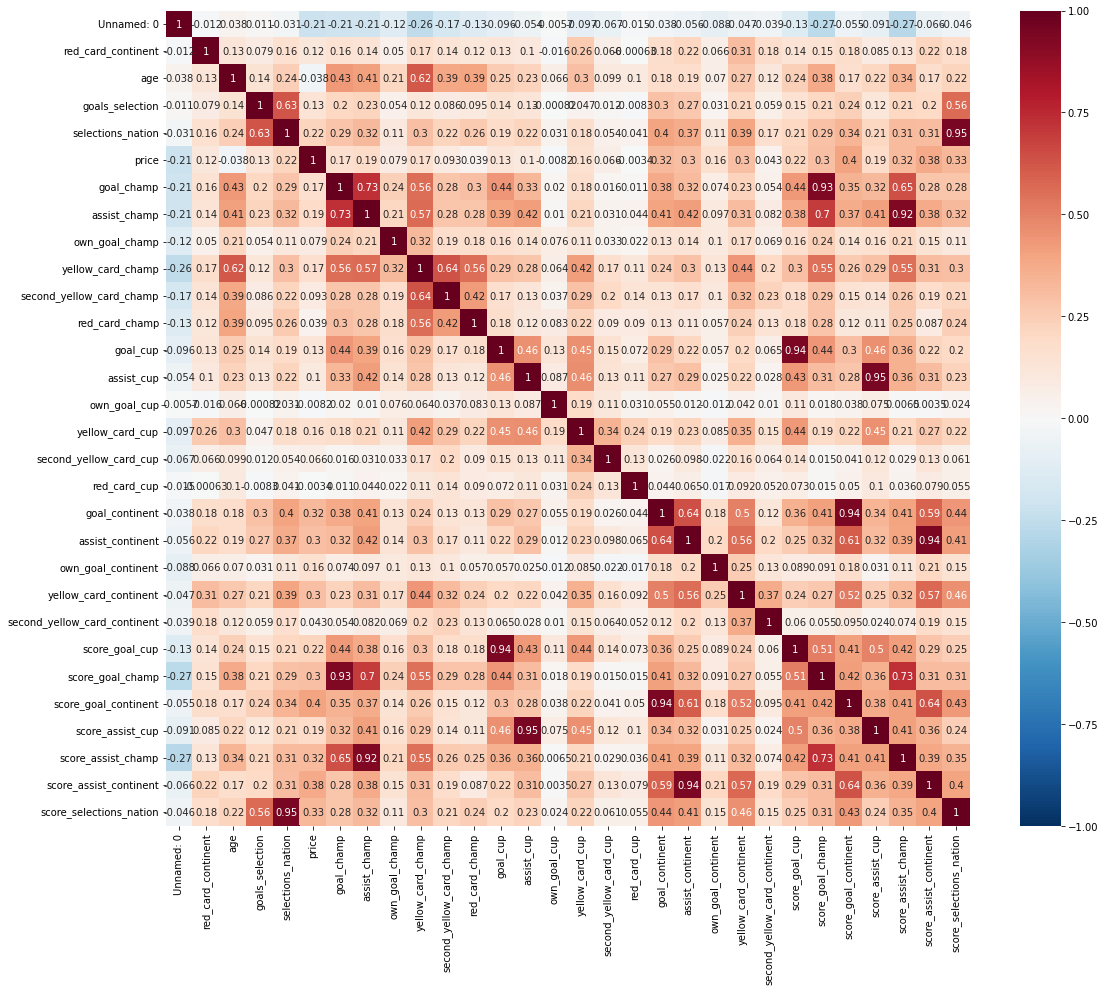

In [190]:
plot_corr(data.filter_by_position(1))

## Midfielders

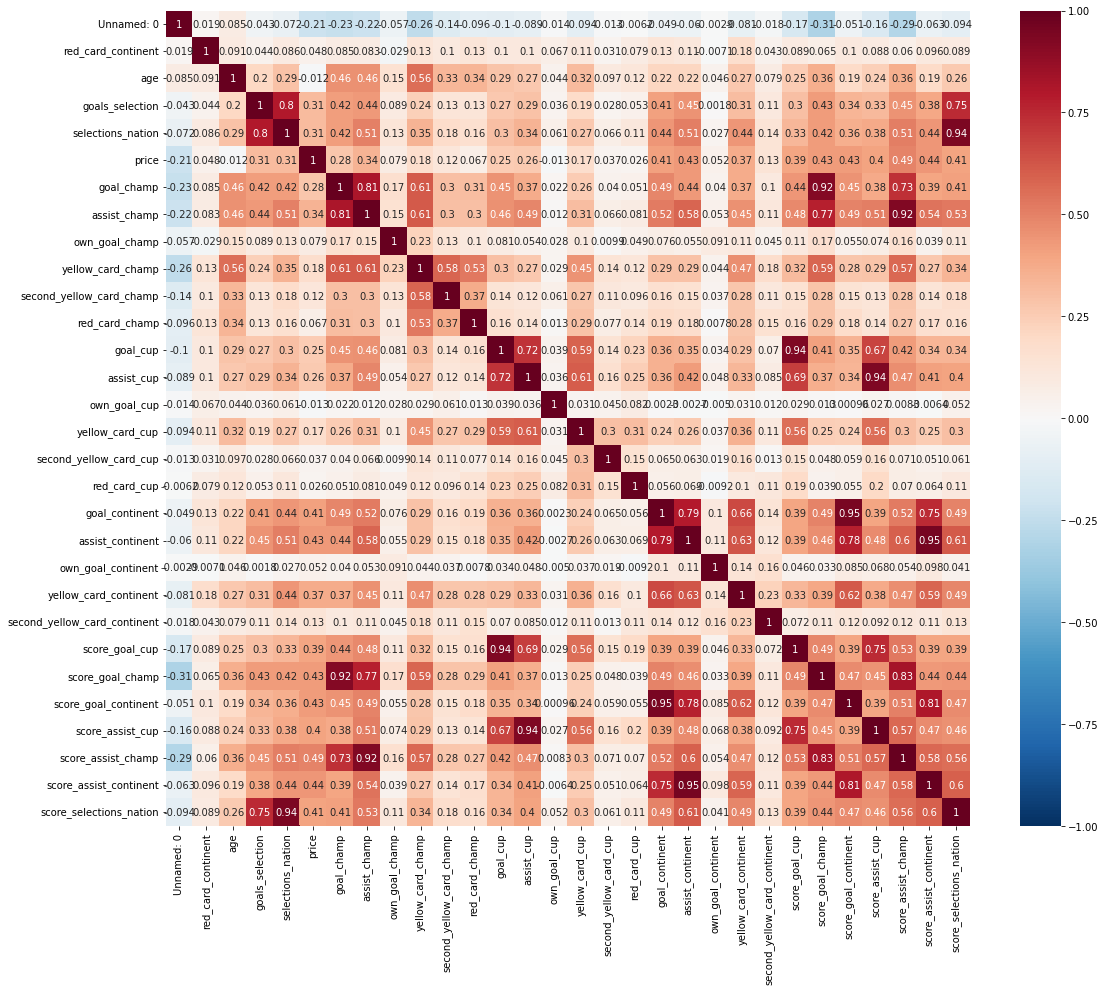

In [191]:
plot_corr(data.filter_by_position(2))

## Forwards

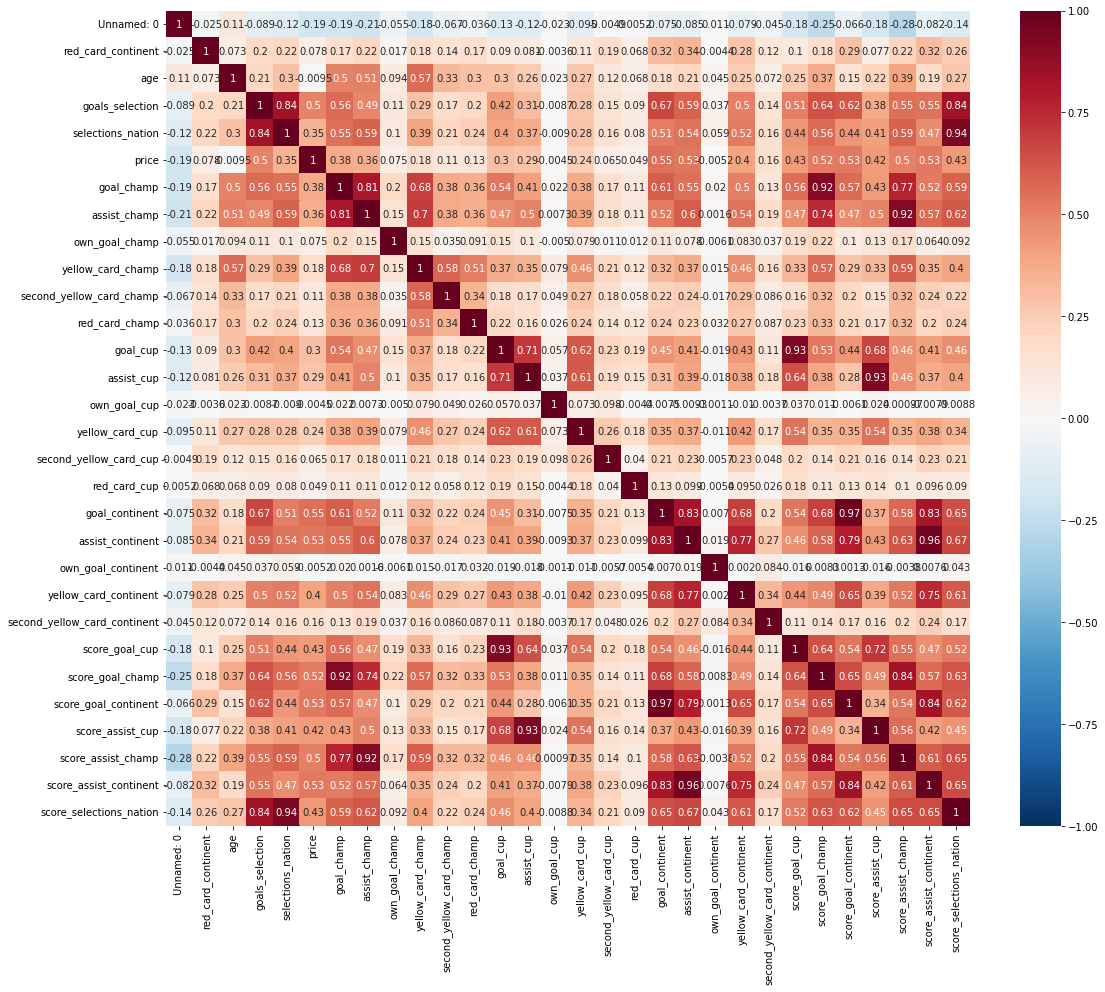

In [192]:
plot_corr(data.filter_by_position(3))

## Forward players in top leagues

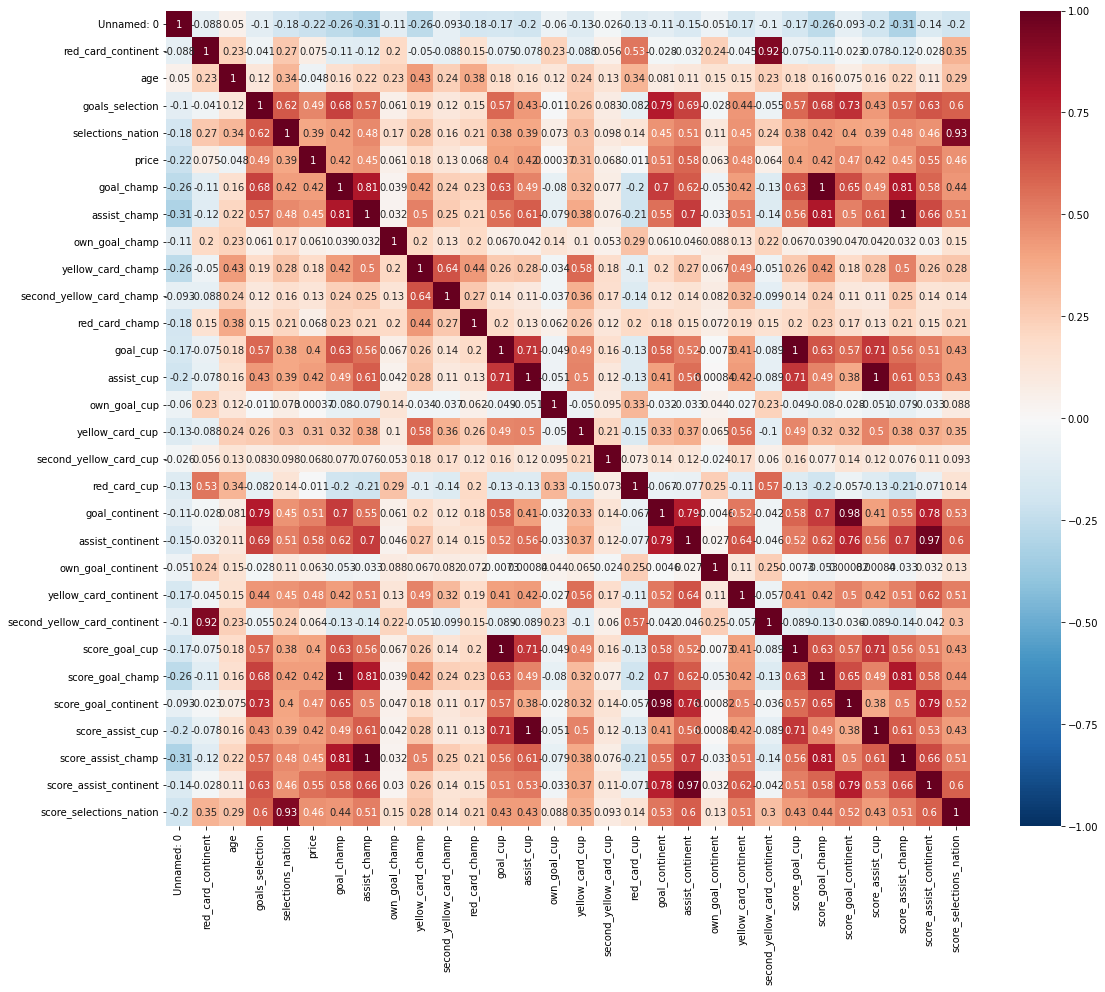

In [193]:
plot_corr(data.filter_top_leagues())

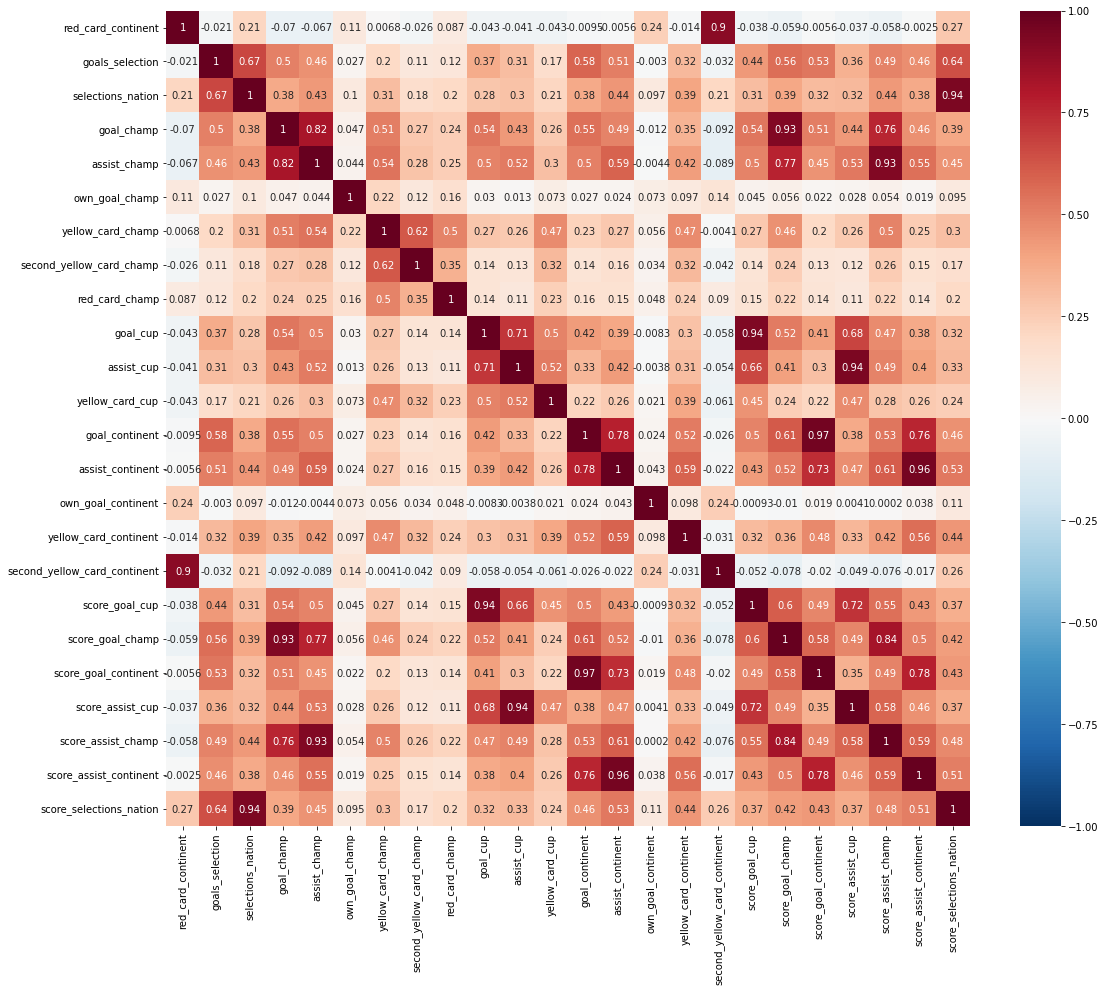

In [194]:
X, y = data.data_correlated()
plot_corr(X)


In [195]:
X.head(2)

,red_card_continent,goals_selection,selections_nation,goal_champ,assist_champ,own_goal_champ,yellow_card_champ,second_yellow_card_champ,red_card_champ,goal_cup,...,own_goal_continent,yellow_card_continent,second_yellow_card_continent,score_goal_cup,score_goal_champ,score_goal_continent,score_assist_cup,score_assist_champ,score_assist_continent,score_selections_nation
0,0.0,0,4,0.0,0.0,0.0,5.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,0.0,0,1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1


### MORE INFO
    * ATTENTION
        - With that data, defenders will be valued poorly. We can't see her performance, because we've got their goals but not how many goals scored the teams against them. Same with Goalkeepers.

    * MISSING INFO
        - Goals /game --> how many minutes to score a goal?
        - Goals in top matches? Finals...
        - Experience in big matches
        - Historical injuries
        - Player mentality
        - Player position during the game
    
    * CURIOUS FACTS TO ADD INFO
        - Goal value increases if the football tendency is to score less goals in a match.
        - Global economy. If more people whats football and moves more money, players value will increase.


    



### LINKS
https://github.com/eddwebster/football_analytics/tree/master/notebooks

https://github.com/JaseZiv/worldfootballR

https://github.com/emordonez/transfermarkt-transfers

https://github.com/sanjitva/Predicting-Football-Player-Transfer-Values